# 神经网络简介

 **学习目标：**
  * 使用 TensorFlow `DNNRegressor` 类定义神经网络 (NN) 及其隐藏层
  * 训练神经网络学习数据集中的非线性规律，并实现比线性回归模型更好的效果

## 设置

In [1]:
%matplotlib inline
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [2]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

In [3]:
# 训练集
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# 验证集
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2658.2,542.8,1435.7,504.1,3.9,2.0
std,2.1,2.0,12.6,2200.9,427.1,1170.9,389.0,1.9,1.3
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1468.0,297.0,792.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2129.5,435.0,1171.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3174.0,653.0,1724.2,609.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.7,2608.7,531.3,1415.0,494.4,3.9,2.0
std,2.1,2.0,12.6,2128.6,407.6,1090.6,373.6,1.9,0.9
min,32.5,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1441.2,295.0,783.0,278.0,2.6,1.5
50%,34.3,-118.5,29.0,2125.0,431.0,1157.0,406.0,3.5,1.9
75%,37.7,-118.0,37.0,3104.8,636.0,1711.2,595.0,4.8,2.3
max,42.0,-114.6,52.0,30405.0,4798.0,12873.0,4490.0,15.0,19.1


Training targets summary:


,median_house_value
count,12000.0
mean,207.6
std,115.6
min,15.0
25%,120.6
50%,181.3
75%,265.0
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.6
std,116.8
min,15.0
25%,118.0
50%,178.4
75%,264.9
max,500.0


 ## 构建神经网络

神经网络由 [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/DNNRegressor) 类定义。

使用 **`hidden_units`** 定义神经网络的结构。`hidden_units` 参数会创建一个整数列表，其中每个整数对应一个隐藏层，表示其中的节点数。以下面的赋值为例：

`hidden_units=[3,10]`

上述赋值为神经网络指定了两个隐藏层：

* 第一个隐藏层包含 3 个节点。
* 第二个隐藏层包含 10 个节点。

如果我们想要添加更多层，可以向该列表添加更多整数。例如，`hidden_units=[10,20,30,40]` 会创建 4 个分别包含 10、20、30 和 40 个单元的隐藏层。

默认情况下，所有隐藏层都会使用 ReLu 激活函数，且是全连接层。

In [4]:
def construct_feature_columns(input_features):
    
    return set([tf.feature_column.numeric_column(my_feature) 
                for my_feature in input_features])

In [5]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [23]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    
    periods = 10
    steps_per_period = steps / periods

    # Create a nn regressor object.
    # my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    # my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
    )

    # 1. Create input functions.
    training_input_fn = lambda: my_input_fn(
        training_examples, 
        training_targets["median_house_value"], 
        batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(
        training_examples, 
        training_targets["median_house_value"], 
        num_epochs=1, 
        shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(
        validation_examples,
        validation_targets["median_house_value"], 
        num_epochs=1, 
        shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period,
        )
        # 2. Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

    return dnn_regressor

## 训练神经网络模型

调整超参数，目标是将 RMSE 降到 110 以下。

运行以下代码块来训练神经网络模型。

我们已经知道，在使用了很多特征的线性回归练习中，110 左右的 RMSE 已经是相当不错的结果。我们将得到比它更好的结果。

我们将修改各种学习设置，以提高在验证数据上的准确率。

对于神经网络而言，过拟合是一种真正的潜在危险。我们可以查看训练数据损失与验证数据损失之间的差值，以帮助判断模型是否有过拟合的趋势。如果差值开始变大，则通常可以肯定存在过拟合。

由于存在很多不同的可能设置，强烈建议记录每次试验，以在开发流程中进行参考。

此外，获得效果出色的设置后，尝试多次运行该设置，看看结果的重复程度。由于神经网络权重通常会初始化为较小的随机值，因此每次运行结果应该存在差异。

Training model...
RMSE (on training data):
  period 00 : 160.47
  period 01 : 135.44
  period 02 : 119.72
  period 03 : 118.88
  period 04 : 109.78
  period 05 : 108.01
  period 06 : 108.21
  period 07 : 106.36
  period 08 : 108.21
  period 09 : 111.20
Model training finished.
Final RMSE (on training data):   111.20
Final RMSE (on validation data): 110.93


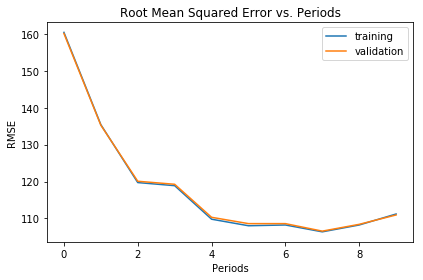

In [17]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 171.59
  period 01 : 143.37
  period 02 : 146.47
  period 03 : 121.91
  period 04 : 112.34
  period 05 : 116.01
  period 06 : 106.20
  period 07 : 105.94
  period 08 : 105.18
  period 09 : 104.77
Model training finished.
Final RMSE (on training data):   104.77
Final RMSE (on validation data): 103.52


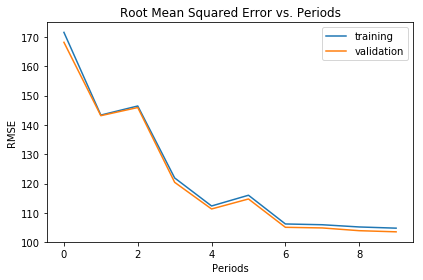

In [24]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 98.74
  period 01 : 107.79
  period 02 : 93.09
  period 03 : 93.72
  period 04 : 91.79
  period 05 : 90.82
  period 06 : 90.80
  period 07 : 90.33
  period 08 : 89.91
  period 09 : 89.37
Model training finished.
Final RMSE (on training data):   89.37
Final RMSE (on validation data): 89.72


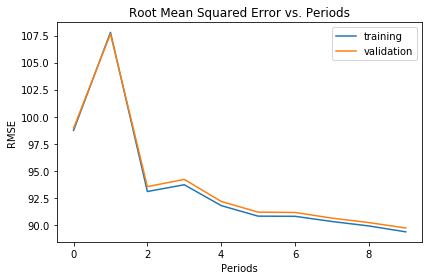

In [25]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 任务 2：用测试数据进行评估

**确认验证效果结果经受得住测试数据的检验。**

获得满意的模型后，用测试数据评估该模型，以与验证效果进行比较。

In [26]:
california_housing_test_data = pd.read_csv("california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["median_house_value"], 
                                               num_epochs=1, 
                                               shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 89.29
